In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
from scipy import stats
from scipy.interpolate import interp1d
from statsmodels.nonparametric.smoothers_lowess import lowess
import seaborn as sns
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.feature_selection import SelectKBest, f_classif
from catboost import CatBoostClassifier, Pool
import shap
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from feature_mapping import *
from sklearn.preprocessing import StandardScaler


/home/atefe_hjn97/Documents/VScode/caspian_second/CASPIAN_env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
df_5 = pd.read_spss('../data/caspian-5.sav',convert_categoricals=True)

In [3]:
categorical_columns = df_5.select_dtypes(include=['object', 'category']).columns
df_5[categorical_columns]

,University,region,cross,sex,a_1,closefriendn,a_2,a_3,spenttimefriend,a_4,...,hp_92_3,hp_93_1,hp_93_2,hp_93_3,hp_93_4,hp_94,hp_95,hp_98,hp_100,hp_101
0,tabriz,urban,elemantry,girl,2 dost,>3friend,0 roz,0 roz,1-3roz,never,...,never,always,always,always,always,no,NaN,mother,normal,normal
1,fasad,urban,intermidiate,girl,1 dost,>=2friend,0 roz,0 roz,1-3roz,never,...,sometimes,rarely,usually,usually,usually,no,NaN,mother,normal,normal
2,ardebil,urban,elemantry,boy,3 or more,>3friend,3 roz,4 roz,>3roz,5 or 6 in week,...,sometimes,always,always,always,always,no,dar raftegi,mother,normal,normal
3,lorestan,urban,elemantry,boy,3 or more,>3friend,0 roz,0 roz,1-3roz,never,...,never,rarely,always,never,always,no,NaN,father,kami laghar,kami laghar
4,kurdestan,rural,intermidiate,boy,3 or more,>3friend,2 roz,1 roz,1-3roz,never,...,sometimes,usually,usually,sometimes,usually,no,NaN,mother,kami laghar,normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13978,charmahal,rural,elemantry,boy,1 dost,>=2friend,0 roz,0 roz,1-3roz,1 or 2 in week,...,sometimes,rarely,always,sometimes,always,no,NaN,mother,normal,kheili laghar
13979,khorasan jonobi,urban,intermidiate,boy,2 dost,>3friend,0 roz,0 roz,1-3roz,1 or 2 in week,...,usually,sometimes,usually,sometimes,usually,no,NaN,father,kami chagh,kami laghar
13980,azar gharbi,urban,elemantry,boy,3 or more,>3friend,0 roz,0 roz,1-3roz,never,...,always,always,sometimes,sometimes,always,no,NaN,mother,kami chagh,kami laghar
13981,arak,urban,intermidiate,girl,2 dost,>3friend,0 roz,0 roz,1-3roz,never,...,sometimes,sometimes,usually,usually,usually,no,NaN,mother,kami laghar,kami laghar


In [4]:
from feature_mapping import map_feature, map_feature_4

# Step 1: Filter the dataset to keep only the features in the dictionary
features_to_keep = map_feature.keys()
df_5_filtered = df_5[list(features_to_keep)]

# Step 2: Rename the features based on the map_feature dictionary
df_5_filtered = df_5_filtered.rename(columns=map_feature)

# Step 3: Display the filtered and renamed dataset
print(df_5_filtered.head())


  university         grade gender  birth_date close_friend_count  \
0     tabriz     elemantry   girl        82.0             2 dost   
1      fasad  intermidiate   girl        81.0             1 dost   
2    ardebil     elemantry    boy        80.0          3 or more   
3   lorestan     elemantry    boy        80.0          3 or more   
4  kurdestan  intermidiate    boy        79.0          3 or more   

  spent_time_friend1 spent_time_friend2 chatting_online   body_image  \
0              0 roz              0 roz           never       normal   
1              0 roz              0 roz           never  kami laghar   
2              3 roz              4 roz  5 or 6 in week       normal   
3              0 roz              0 roz           never       normal   
4              2 roz              1 roz           never       normal   

  diet_plan  ... reduce_fat use_liquid_oil increase_vegetables reduce_sugar  \
0      khub  ...         no             no                 yes          yes   


change ap_17 to ap_21 as livingparent and remove them

In [5]:
def determine_livingparent(row):
    if row["ap_17"] == "yes" and row["ap_18"] == "yes":
        return "Ba hardo"
    elif row["ap_17"] == "yes" or row["ap_18"] == "yes":
        return "Ba yeki az valedayn"
    else:
        return "Napedar v na madar"

df_5_filtered["livingparent"] = df_5_filtered.apply(determine_livingparent, axis=1)
df_5_filtered.drop(['ap_17','ap_18','ap_19','ap_20','ap_21'],axis=1,inplace=True)
df_5_filtered['source']='casp 5'

In [6]:
df_5_filtered.shape

(13983, 128)

In [7]:
categorical_columns = df_5_filtered.select_dtypes(include=['object', 'category']).columns
df_5_filtered[categorical_columns]

,university,grade,gender,close_friend_count,spent_time_friend1,spent_time_friend2,chatting_online,body_image,diet_plan,breakfast_routindays,...,increase_vegetables,reduce_sugar,reduce_salt,reduce_fast_food,fruit_nut_substitute,injury_parent_ask,injury_complication,region,livingparent,source
0,tabriz,elemantry,girl,2 dost,0 roz,0 roz,never,normal,khub,6ruz,...,yes,yes,yes,yes,yes,no,NaN,urban,Ba hardo,casp 5
1,fasad,intermidiate,girl,1 dost,0 roz,0 roz,never,kami laghar,khub,6ruz,...,yes,no,yes,yes,yes,no,NaN,urban,Ba hardo,casp 5
2,ardebil,elemantry,boy,3 or more,3 roz,4 roz,5 or 6 in week,normal,yes,6ruz,...,no,no,no,no,NaN,no,dar raftegi,urban,Ba yeki az valedayn,casp 5
3,lorestan,elemantry,boy,3 or more,0 roz,0 roz,never,normal,khub,3ruz,...,yes,yes,no,yes,yes,no,NaN,urban,Ba hardo,casp 5
4,kurdestan,intermidiate,boy,3 or more,2 roz,1 roz,never,normal,khub,6ruz,...,yes,yes,yes,yes,yes,no,NaN,rural,Ba yeki az valedayn,casp 5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13978,charmahal,elemantry,boy,1 dost,0 roz,0 roz,1 or 2 in week,normal,khub,5ruz,...,no,no,no,no,no,no,NaN,rural,Ba hardo,casp 5
13979,khorasan jonobi,intermidiate,boy,2 dost,0 roz,0 roz,1 or 2 in week,kami chagh,yes,6ruz,...,yes,yes,no,yes,yes,no,NaN,urban,Ba hardo,casp 5
13980,azar gharbi,elemantry,boy,3 or more,0 roz,0 roz,never,normal,kam konam,6ruz,...,no,yes,no,yes,yes,no,NaN,urban,Ba hardo,casp 5
13981,arak,intermidiate,girl,2 dost,0 roz,0 roz,never,normal,khub,6ruz,...,no,no,no,no,no,no,NaN,urban,Ba hardo,casp 5


upload dataset 4

In [8]:
from feature_mapping import map_feature_4
df_4 = pd.read_spss('../final_data/caspian4-ghorbani.sav')
features_to_keep = map_feature_4.keys()
df_4_filtered = df_4[list(features_to_keep)]

df_4_filtered = df_4_filtered.rename(columns=map_feature_4)
df_4_filtered['source']='casp 4'
# Step 4: Display the filtered dataset
print(df_4_filtered.head())

        university      grade gender  birth_date close_friend_count  \
0  khozestan-ahvaz  rahnamayi    boy        79.0               yeki   
1  khozestan-ahvaz  rahnamayi    boy        74.0     3ta va bishtar   
2          boshehr   ebtedayi   girl        80.0     3ta va bishtar   
3          ardabil  rahnamayi   girl        78.0                2ta   
4          ardabil   ebtedayi   girl        81.0               yeki   

  spent_time_friend1 spent_time_friend2       chatting_online body_image  \
0           hich ruz               3ruz  5 ya 6 ruz dar hafte  kami chag   
1               2ruz               2ruz   1 ya 2ruz dar hafte     normal   
2           hich ruz               2ruz  5 ya 6 ruz dar hafte  kamilagar   
3               5ruz               4ruz  3 ya 4 ruz dar hafte  kamilagar   
4               1ruz               1ruz   1 ya 2ruz dar hafte     normal   

      diet_plan  ... reduce_fast_food increase_vegetables reduce_salt  \
0  no wt ok ast  ...               no      

In [9]:
# combined_df = pd.concat([df_4_filtered, df_5_filtered], ignore_index=True)
combined_df = df_5_filtered
# Display the combined dataset
combined_df.shape

(13983, 128)

In [10]:
import re
combined_df.replace('', np.nan, inplace=True)
combined_df.replace('rarely','seldom/never',inplace=True)
combined_df.replace('never','seldom/never',inplace=True)

combined_df.replace('hichvaght','seldom/never',inplace=True)
combined_df.replace({'hich ruz': '0 day', 'hich ruzi': '0 day'}, inplace=True)

categorical_columns = combined_df.select_dtypes(include=['object', 'category']).columns
for col in categorical_columns:
    combined_df[col] = combined_df[col].apply(lambda x: x.lower() if isinstance(x, str) and x != '' else np.nan)
    combined_df[col] = combined_df[col].apply(lambda x: x.strip() if isinstance(x, str) and x != '' else np.nan)
    combined_df[col] = combined_df[col].apply(lambda x: re.sub(r'(\d)(\w)', r'\1 \2', str(x)) if isinstance(x, str) else x)
    combined_df[col] = combined_df[col].apply(lambda x: str(x).replace('ruzi', 'day').replace('ruz', 'day').replace('roz', 'day') if isinstance(x, str) else x)
    combined_df[col] = combined_df[col].apply(lambda x: str(x).replace('hours', 'hour').replace('saat', 'hour') if isinstance(x, str) else x)
    combined_df[col] = combined_df[col].apply(lambda x: re.sub(r'(\d)\s*ta\s*(\d)', r'\1-\2', str(x)) if isinstance(x, str) else x)
    

In [11]:
categorical_columns = combined_df.select_dtypes(include=['object', 'category']).columns
combined_df[categorical_columns]

,university,grade,gender,close_friend_count,spent_time_friend1,spent_time_friend2,chatting_online,body_image,diet_plan,breakfast_routindays,...,increase_vegetables,reduce_sugar,reduce_salt,reduce_fast_food,fruit_nut_substitute,injury_parent_ask,injury_complication,region,livingparent,source
0,tabriz,elemantry,girl,2 dost,0 day,0 day,seldom/never,normal,khub,6 day,...,yes,yes,yes,yes,yes,no,NaN,urban,ba hardo,casp 5
1,fasad,intermidiate,girl,1 dost,0 day,0 day,seldom/never,kami laghar,khub,6 day,...,yes,no,yes,yes,yes,no,NaN,urban,ba hardo,casp 5
2,ardebil,elemantry,boy,3 or more,3 day,4 day,5 or 6 in week,normal,yes,6 day,...,no,no,no,no,NaN,no,dar raftegi,urban,ba yeki az valedayn,casp 5
3,lorestan,elemantry,boy,3 or more,0 day,0 day,seldom/never,normal,khub,3 day,...,yes,yes,no,yes,yes,no,NaN,urban,ba hardo,casp 5
4,kurdestan,intermidiate,boy,3 or more,2 day,1 day,seldom/never,normal,khub,6 day,...,yes,yes,yes,yes,yes,no,NaN,rural,ba yeki az valedayn,casp 5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13978,charmahal,elemantry,boy,1 dost,0 day,0 day,1 or 2 in week,normal,khub,5 day,...,no,no,no,no,no,no,NaN,rural,ba hardo,casp 5
13979,khorasan jonobi,intermidiate,boy,2 dost,0 day,0 day,1 or 2 in week,kami chagh,yes,6 day,...,yes,yes,no,yes,yes,no,NaN,urban,ba hardo,casp 5
13980,azar gharbi,elemantry,boy,3 or more,0 day,0 day,seldom/never,normal,kam konam,6 day,...,no,yes,no,yes,yes,no,NaN,urban,ba hardo,casp 5
13981,arak,intermidiate,girl,2 dost,0 day,0 day,seldom/never,normal,khub,6 day,...,no,no,no,no,no,no,NaN,urban,ba hardo,casp 5


In [ ]:
# Standardize column names
df_4_filtered.columns = df_4_filtered.columns.str.strip().str.lower()
df_5_filtered.columns = df_5_filtered.columns.str.strip().str.lower()

# Compare again
print("Columns in df1 but not in df2:", set(df_4_filtered.columns) - set(df_5_filtered.columns))
print("Columns in df2 but not in df1:", set(df_5_filtered.columns) - set(df_4_filtered.columns))


In [12]:
categorical_columns = combined_df.select_dtypes(include=['object', 'category']).columns

# Get unique values for each categorical column
unique_values = {col: combined_df[col].dropna().unique().tolist() for col in categorical_columns}

# Print the results
for col, values in unique_values.items():
    print(f"Column: {col}, Unique Values: {values}")

Column: university, Unique Values: ['tabriz', 'fasad', 'ardebil', 'lorestan', 'kurdestan', 'boshehr', 'khorasan shomali', 'charmahal', 'khorasan jonobi', 'azar gharbi', 'mazandaran', 'kohkiloyeh', 'golestan', 'babol', 'rafsanjan', 'kermanshah', 'zabol', 'hormozgan', 'arak', 'khozestan', 'kerman', 'semnan', 'hamedan', 'tehran', 'behbahan', 'kerman.jiroft', 'khorasan razavi', 'ilam', 'esfarayen', 'yazd', 'iran', 'saveh', 'alborz', 'zanjan', 'dezful', 'neishabor', 'qazvin', 'abadan', 'torbat jam', 'fars', 'iranshahr', 'gilan', 'shahidbeheshti', 'torbat heidariyeh', 'sistan', 'bam', 'shahrood', 'isfahan', 'sabzevar', 'jahrom', 'kashan', 'shoshtar', 'larestan']
Column: grade, Unique Values: ['elemantry', 'intermidiate']
Column: gender, Unique Values: ['girl', 'boy']
Column: close_friend_count, Unique Values: ['2 dost', '1 dost', '3 or more', 'nadarad']
Column: spent_time_friend1, Unique Values: ['0 day', '3 day', '2 day', '1 day', '6 day', '5 day', '4 day']
Column: spent_time_friend2, Uniqu

In [13]:
from feature_mapping import mapping_university
combined_df['university'] = combined_df['university'].apply(lambda x: mapping_university.get(x, x))

In [14]:
from feature_mapping import mapping_grade
combined_df['grade'] = combined_df['grade'].apply(lambda x: mapping_grade.get(x, x))

In [15]:
from feature_mapping import mapping_close_friend_count
combined_df['close_friend_count'] = combined_df['close_friend_count'].apply(lambda x: mapping_close_friend_count.get(x, x))

In [16]:
from feature_mapping import mapping_chatting_online
combined_df['chatting_online'] = combined_df['chatting_online'].apply(lambda x: mapping_chatting_online.get(x, x))

In [17]:
from feature_mapping import mapping_body_img
combined_df['body_image'] = combined_df['body_image'].apply(lambda x: mapping_body_img.get(x, x))

In [18]:
from feature_mapping import mapping_diet_plan
combined_df['diet_plan'] = combined_df['diet_plan'].apply(lambda x: mapping_diet_plan.get(x, x))

In [19]:
from feature_mapping import mapping_breakfast_routindays
combined_df['breakfast_routindays'] = combined_df['breakfast_routindays'].apply(lambda x: mapping_breakfast_routindays.get(x, x))

In [20]:
from feature_mapping import mapping_breakfast_friday
combined_df['breakfast_friday'] = combined_df['breakfast_friday'].apply(lambda x: mapping_breakfast_friday.get(x, x))

In [21]:
from feature_mapping import mapping_lunch_routindays,mapping_lunch_friday,mapping_dinner_routindays
combined_df['lunch_routinday'] = combined_df['lunch_routinday'].apply(lambda x: mapping_lunch_routindays.get(x, x))
combined_df['lunch_friday'] = combined_df['lunch_friday'].apply(lambda x: mapping_lunch_friday.get(x, x))
combined_df['dinner_routinday'] = combined_df['dinner_routinday'].apply(lambda x: mapping_dinner_routindays.get(x, x))
combined_df['dinner_friday'] = combined_df['dinner_friday'].apply(lambda x: mapping_lunch_friday.get(x, x))


In [23]:
from feature_mapping import mapping_screen_timing
combined_df['TV_watching_routinday'] = combined_df['TV_watching_routinday'].apply(lambda x: mapping_screen_timing.get(x, x))
combined_df['TV_watching_friday'] = combined_df['TV_watching_friday'].apply(lambda x: mapping_screen_timing.get(x, x))
combined_df['computer_work_routinday'] = combined_df['computer_work_routinday'].apply(lambda x: mapping_screen_timing.get(x, x))
combined_df['computer_work_friday'] = combined_df['computer_work_friday'].apply(lambda x: mapping_screen_timing.get(x, x))

In [24]:
from feature_mapping import (
    mapping_injury_times,
    mapping_injury_place,
    mapping_injury_treatment_place,
    mapping_fight_number,
    mappling_litigant,
    mapping_carry_weapons,
    mapping_victim_number,
    mapping_bully_number,
)
from feature_mapping import mapping_injury_cause

combined_df["injury_number"] = combined_df["injury_number"].apply(
    lambda x: mapping_injury_times.get(x, x)
)
combined_df["injury_place"] = combined_df["injury_place"].apply(
    lambda x: mapping_injury_place.get(x, x)
)
combined_df["injury_cause"] = combined_df["injury_cause"].apply(
    lambda x: mapping_injury_cause.get(x, x)
)
combined_df["injury_treatment_place"] = combined_df["injury_treatment_place"].apply(
    lambda x: mapping_injury_treatment_place.get(x, x)
)
combined_df["fight_number"] = combined_df["fight_number"].apply(
    lambda x: mapping_fight_number.get(x, x)
)
combined_df["litigant"] = combined_df["litigant"].apply(
    lambda x: mappling_litigant.get(x, x)
)
combined_df["carry_weapons"] = combined_df["carry_weapons"].apply(
    lambda x: mapping_carry_weapons.get(x, x)
)
combined_df["victim_number"] = combined_df["victim_number"].apply(
    lambda x: mapping_victim_number.get(x, x)
)
combined_df["bully_number"] = combined_df["bully_number"].apply(
    lambda x: mapping_bully_number.get(x, x)
)


In [25]:
from feature_mapping import mapping_feeling_number

feeling = [
    "confusion_number",
    "worthless_number",
    "insomnia_number",
    "back_pain_number",
    "headache_number",
    "worried_number",
    "stomach_ache_number",
    "angriness_number",
]
for col in feeling:
    combined_df[col] = combined_df[col].apply(
        lambda x: mapping_feeling_number.get(x, x)
    )

In [26]:
from feature_mapping import mapping_depression
combined_df['depression']=combined_df['depression'].apply(lambda x: mapping_depression.get(x,x))

In [27]:
from feature_mapping import mapping_anxiety
combined_df['anxiety_number']=combined_df['anxiety_number'].apply(lambda x: mapping_anxiety.get(x,x))

In [28]:
from feature_mapping import mappingـmental_health
combined_df['mental_health_overview']=combined_df['mental_health_overview'].apply(lambda x: mappingـmental_health.get(x,x))

In [29]:
from feature_mapping import mapping_catage
combined_df = combined_df[(combined_df['age'] >= 7) & (combined_df['age'] <= 18)]
combined_df['catage']=combined_df['catage'].apply(lambda x: mapping_catage.get(x,x))
combined_df['catage'].value_counts()


1    5463
0    4748
2    3772
Name: catage, dtype: int64

In [30]:
from feature_mapping import mapping_smoking_type
combined_df['smoking_type']=combined_df['smoking_type'].apply(lambda x: mapping_smoking_type.get(x,x))

In [31]:
from feature_mapping import mapping_home_ownership
combined_df['home_ownership']=combined_df['home_ownership'].apply(lambda x: mapping_home_ownership.get(x,x))

In [32]:
from feature_mapping import mapping_edu
combined_df['father_edu']=combined_df['father_edu'].apply(lambda x: mapping_edu.get(x,x))
combined_df['mother_edu']=combined_df['mother_edu'].apply(lambda x: mapping_edu.get(x,x))


In [33]:
from feature_mapping import (
    father_job_mapping,
    mother_job_mapping,
    school_type_mapping,
    birth_weight_mapping,
    milk_type_mapping,
    complementary_feeding_mapping,
)

combined_df["father_job"] = combined_df["father_job"].apply(
    lambda x: father_job_mapping.get(x, x)
)
combined_df["mother_job"] = combined_df["mother_job"].apply(
    lambda x: mother_job_mapping.get(x, x)
)
combined_df["school_type"] = combined_df["school_type"].apply(
    lambda x: school_type_mapping.get(x, x)
)
combined_df["birth_weight"] = combined_df["birth_weight"].apply(
    lambda x: birth_weight_mapping.get(x, x)
)
combined_df["milk_type"] = combined_df["milk_type"].apply(
    lambda x: milk_type_mapping.get(x, x)
)
combined_df["complementary_feeding"] = combined_df["complementary_feeding"].apply(
    lambda x: complementary_feeding_mapping.get(x, x)
)


In [34]:
combined_df['bread_type'].replace({
    'bedune sabus': 'White bread',
    'sabusdar': 'whole grain bread',
    'sabus dar': 'whole grain bread'
},inplace=True)



In [35]:
combined_df['oil_type']=combined_df['oil_type'].apply(lambda x:oil_type_mapping.get(x,x))
combined_df['table_salt']=combined_df['table_salt'].apply(lambda x:table_salt_mapping.get(x,x))
combined_df['dairy_type']=combined_df['dairy_type'].apply(lambda x:dairy_type_mapping.get(x,x))
combined_df['injury_complication']= combined_df['injury_complication'].apply(lambda x:injury_complication_mapping.get(x,x))

In [36]:
categorical_columns = combined_df.select_dtypes(include=['object', 'category']).columns
# Get unique values for each categorical column
unique_values = {col: combined_df[col].dropna().unique().tolist() for col in categorical_columns}

# Print the results
for col, values in unique_values.items():
    print(f"Column: {col}, Unique Values: {values}")

Column: university, Unique Values: ['tabriz', 'fasa', 'ardabil', 'lorestan', 'kordestan', 'bushehr', 'khorasan shomali', 'chaharmahal bakhtiyari', 'khorasan jonoubi', 'azar gharbi', 'mazandaran', 'kohgiluyeh', 'golestan', 'babol', 'rafsanjan', 'kermanshah', 'zabol', 'hormozgan', 'arak', 'khozestan', 'kerman', 'semnan', 'hamedan', 'tehran', 'behbahan', 'jiroft', 'khorasan razavi', 'ilam', 'esfarayen', 'yazd', 'iran', 'saveh', 'alborz', 'zanjan', 'dezful', 'neishabor', 'qazvin', 'abadan', 'torbat jam', 'fars', 'iranshahr', 'gilan', 'shahid beheshti', 'torbat heidariyeh', 'sistan', 'bam', 'shahrood', 'isfahan', 'sabzevar', 'jahrom', 'kashan', 'shushtar', 'larestan']
Column: grade, Unique Values: ['elementary', 'intermediate']
Column: gender, Unique Values: ['girl', 'boy']
Column: close_friend_count, Unique Values: ['two', 'one', 'three or more', 'any']
Column: spent_time_friend1, Unique Values: ['0 day', '3 day', '2 day', '1 day', '6 day', '5 day', '4 day']
Column: spent_time_friend2, Uni

In [37]:
!pwd

/home/atefe_hjn97/Documents/VScode/caspian_second/casp 5


In [101]:
# combined_df.to_csv('combined_data_alignment_4&5_v1.csv')

missing value handling

In [38]:
df=combined_df.copy()
df = df[df['source']=='casp 5']
# df = df[df['gender']=='girl']

drop column with over 80 percent missing value

In [39]:
to_drop_col = []
for column in df.columns:
    null_percentage = df[column].isnull().mean()*100
    print(f"Column '{column}' has {null_percentage} null values.")
    if null_percentage>20:
        to_drop_col.append(column)
print(df.shape)
df=df.drop(to_drop_col,axis=1)
print(df.shape)
print(to_drop_col)


Column 'university' has 0.0 null values.
Column 'grade' has 0.0 null values.
Column 'gender' has 0.0 null values.
Column 'birth_date' has 0.0 null values.
Column 'close_friend_count' has 0.21454623471358078 null values.
Column 'spent_time_friend1' has 0.1930916112422227 null values.
Column 'spent_time_friend2' has 0.0715154115711936 null values.
Column 'chatting_online' has 0.11442465851390976 null values.
Column 'body_image' has 0.04290924694271615 null values.
Column 'diet_plan' has 0.657941786454981 null values.
Column 'breakfast_routindays' has 0.1716369877708646 null values.
Column 'breakfast_friday' has 0.836730315382965 null values.
Column 'lunch_routinday' has 0.20024315239934204 null values.
Column 'lunch_friday' has 0.8009726095973682 null values.
Column 'dinner_routinday' has 0.0858184938854323 null values.
Column 'dinner_friday' has 0.7008510333976972 null values.
Column 'sweet' has 0.00715154115711936 null values.
Column 'saltysnack' has 0.42194092827004215 null values.
Co

fill null value

In [40]:
categorical_columns = df.select_dtypes(include=['object', 'category']).columns.tolist()
numerical_columns = df.select_dtypes(include=['number']).columns.tolist()
for col in numerical_columns:
    if df[col].isna().any():  # Only process columns with missing values
        df[col] = df.groupby('age')[col].transform(
            lambda x: x.fillna(x.mean())
        )
for col in categorical_columns:
    # Fill null values with the mode of the column within each age group
    if df[col].isna().any():  # Only process columns with missing values
        df[col] = df.groupby('age')[col].transform(
            lambda x: x.fillna(x.mode().iloc[0] if not x.mode().empty else np.nan)
        )

In [41]:
categorical_columns = df.select_dtypes(include=['object', 'category']).columns
df[categorical_columns]

,university,grade,gender,close_friend_count,spent_time_friend1,spent_time_friend2,chatting_online,body_image,diet_plan,breakfast_routindays,...,use_liquid_oil,increase_vegetables,reduce_sugar,reduce_salt,reduce_fast_food,fruit_nut_substitute,injury_parent_ask,region,livingparent,source
0,tabriz,elementary,girl,two,0 day,0 day,seldom/never,normal weight,weight is fine,6 day,...,no,yes,yes,yes,yes,yes,no,urban,ba hardo,casp 5
1,fasa,intermediate,girl,one,0 day,0 day,seldom/never,slightly underweight,weight is fine,6 day,...,yes,yes,no,yes,yes,yes,no,urban,ba hardo,casp 5
2,ardabil,elementary,boy,three or more,3 day,4 day,5 or 6 day a week,normal weight,yes,6 day,...,no,no,no,no,no,yes,no,urban,ba yeki az valedayn,casp 5
3,lorestan,elementary,boy,three or more,0 day,0 day,seldom/never,normal weight,weight is fine,3 day,...,yes,yes,yes,no,yes,yes,no,urban,ba hardo,casp 5
4,kordestan,intermediate,boy,three or more,2 day,1 day,seldom/never,normal weight,weight is fine,6 day,...,yes,yes,yes,yes,yes,yes,no,rural,ba yeki az valedayn,casp 5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13978,chaharmahal bakhtiyari,elementary,boy,one,0 day,0 day,1 or 2 day a week,normal weight,weight is fine,5 day,...,no,no,no,no,no,no,no,rural,ba hardo,casp 5
13979,khorasan jonoubi,intermediate,boy,two,0 day,0 day,1 or 2 day a week,slightly overweight,yes,6 day,...,yes,yes,yes,no,yes,yes,no,urban,ba hardo,casp 5
13980,azar gharbi,elementary,boy,three or more,0 day,0 day,seldom/never,normal weight,"no, but it should be reduced",6 day,...,no,no,yes,no,yes,yes,no,urban,ba hardo,casp 5
13981,arak,intermediate,girl,two,0 day,0 day,seldom/never,normal weight,weight is fine,6 day,...,no,no,no,no,no,no,no,urban,ba hardo,casp 5


bmi calculation

In [42]:
df["bmi"] = df["weight"] / ((df["height"] / 100) ** 2)

In [43]:
df_who_ref = pd.read_excel('../WHO_tables/bmi-boys-perc-who2007-exp.xlsx')
# Define the age range and convert it to months
age_years = list(range(7, 19))  # From 7 to 18 years inclusive
age_months = [age * 12 for age in age_years]

# Filter the dataset for the specified months and select relevant columns
who_df = df_who_ref[df_who_ref['Month'].isin(age_months)][['Month', 'P5', 'P15', 'P85', 'P95']]

# Map months back to years for clarity
who_df['Age'] = who_df['Month'] // 12
filtered_df = who_df.drop(columns=['Month'])

who_df = who_df.reset_index(drop=True)
who_df

,Month,P5,P15,P85,P95,Age
0,84,13.504,14.166,17.111,18.261,7
1,96,13.666,14.350,17.508,18.802,8
2,108,13.866,14.579,17.987,19.453,9
3,120,14.127,14.875,18.568,20.225,10
4,132,14.469,15.260,19.260,21.113,11
5,144,14.891,15.734,20.052,22.090,12
6,156,15.402,16.303,20.943,23.144,13
7,168,15.976,16.941,21.891,24.221,14
8,180,16.547,17.580,22.812,25.229,15
9,192,17.078,18.176,23.656,26.126,16


In [44]:
def calculate_percentile_labels(row, who_ref):
    """
    Categorizes BMI based on WHO reference percentiles for the corresponding age.
    """
    age = row['age']
    bmi = row['bmi']
    
    # Filter WHO reference data for the specific age
    ref_data = who_ref[who_ref['Age'] == age]
    
    if ref_data.empty:
        return 'Unknown'  # Handle cases where reference data is not available
    
    # Extract the percentiles
    p5 = ref_data['P5'].values[0]
    p85 = ref_data['P85'].values[0]
    p95 = ref_data['P95'].values[0]
    
    # Categorize based on percentiles
    if bmi < p5:
        return 'underweight'
    elif p5 <= bmi < p85:
        return 'normal'
    elif p85 <= bmi < p95:
        return 'overweight'
    else:
        return 'obese'

def calculate_percentiles(df_org, who_ref):
    """
    Adds a percentile category for each row based on WHO reference data.
    """
    df = df_org.copy()
    
    # Apply the function to calculate percentile categories
    df['bmi_category'] = df.apply(
        lambda row: calculate_percentile_labels(row, who_ref), axis=1
    )

    return df

In [45]:
# Use the WHO reference dataframe (df_who_ref)
df = calculate_percentiles(df, who_df)

df[['age','bmi','height','weight','bmi_category']].head()


,age,bmi,height,weight,bmi_category
0,12.0,24.238227,152.000000,56.000000,obese
1,13.0,16.444594,154.000000,39.000000,normal
2,14.0,18.902038,156.000000,46.000000,normal
3,14.0,15.245707,151.300003,34.900002,underweight
4,15.0,17.781971,166.000000,49.000000,normal


In [46]:
categorical_columns = df.select_dtypes(include=['object', 'category']).columns
df[categorical_columns]

,university,grade,gender,close_friend_count,spent_time_friend1,spent_time_friend2,chatting_online,body_image,diet_plan,breakfast_routindays,...,increase_vegetables,reduce_sugar,reduce_salt,reduce_fast_food,fruit_nut_substitute,injury_parent_ask,region,livingparent,source,bmi_category
0,tabriz,elementary,girl,two,0 day,0 day,seldom/never,normal weight,weight is fine,6 day,...,yes,yes,yes,yes,yes,no,urban,ba hardo,casp 5,obese
1,fasa,intermediate,girl,one,0 day,0 day,seldom/never,slightly underweight,weight is fine,6 day,...,yes,no,yes,yes,yes,no,urban,ba hardo,casp 5,normal
2,ardabil,elementary,boy,three or more,3 day,4 day,5 or 6 day a week,normal weight,yes,6 day,...,no,no,no,no,yes,no,urban,ba yeki az valedayn,casp 5,normal
3,lorestan,elementary,boy,three or more,0 day,0 day,seldom/never,normal weight,weight is fine,3 day,...,yes,yes,no,yes,yes,no,urban,ba hardo,casp 5,underweight
4,kordestan,intermediate,boy,three or more,2 day,1 day,seldom/never,normal weight,weight is fine,6 day,...,yes,yes,yes,yes,yes,no,rural,ba yeki az valedayn,casp 5,normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13978,chaharmahal bakhtiyari,elementary,boy,one,0 day,0 day,1 or 2 day a week,normal weight,weight is fine,5 day,...,no,no,no,no,no,no,rural,ba hardo,casp 5,normal
13979,khorasan jonoubi,intermediate,boy,two,0 day,0 day,1 or 2 day a week,slightly overweight,yes,6 day,...,yes,yes,no,yes,yes,no,urban,ba hardo,casp 5,normal
13980,azar gharbi,elementary,boy,three or more,0 day,0 day,seldom/never,normal weight,"no, but it should be reduced",6 day,...,no,yes,no,yes,yes,no,urban,ba hardo,casp 5,normal
13981,arak,intermediate,girl,two,0 day,0 day,seldom/never,normal weight,weight is fine,6 day,...,no,no,no,no,no,no,urban,ba hardo,casp 5,normal


/tmp/ipykernel_76085/159732643.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=category_counts.index, y=category_counts.values, palette='viridis')


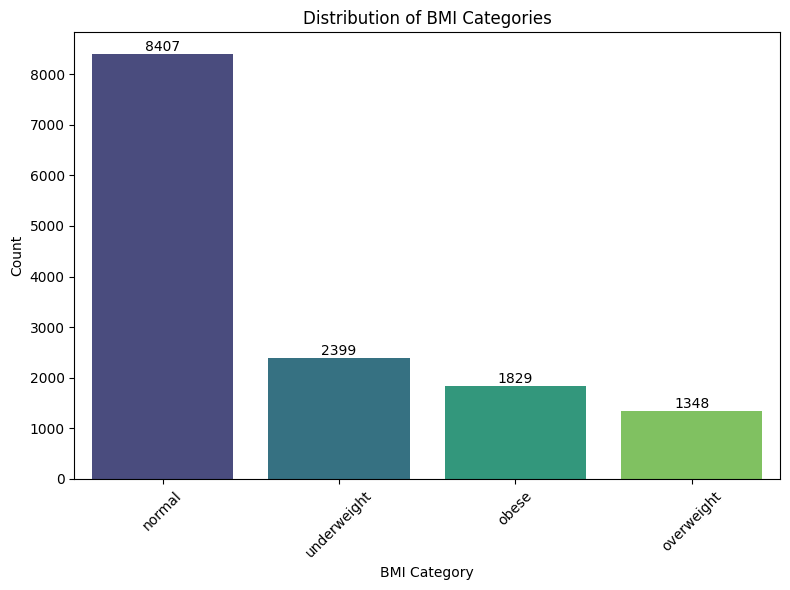

In [47]:
def plot_bmi_categories(df, feature):

        category_counts = df[f'{feature}_category'].value_counts()

        # Plot the counts
        plt.figure(figsize=(8, 6))
        ax = sns.barplot(x=category_counts.index, y=category_counts.values, palette='viridis')

        # Annotate counts above each bar
        for i, count in enumerate(category_counts.values):
            ax.text(i, count + 0.5, str(count), ha='center', va='bottom', fontsize=10)

        # Customize plot
        plt.title(f"Distribution of BMI Categories")
        plt.xlabel("BMI Category")
        plt.ylabel("Count")
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

plot_bmi_categories(df,'bmi')


In [110]:
# def frequency_encode(df, categorical_columns,numerical_columns, group_by_column='age'):
#     """
#     Applies frequency encoding to the specified columns in the dataframe, filling null values with the mode based on each age group.

#     Parameters:
#         df (pd.DataFrame): The input dataframe.
#         columns (list): List of categorical columns to be frequency encoded.
#         group_by_column (str): The column name to group by (default is 'age').

#     Returns:
#         pd.DataFrame: A dataframe with frequency-encoded columns.
#     """
#     df_encoded = df.copy()

#     for col in categorical_columns:
#         # Calculate the frequency for encoding after filling missing values
#         if col != 'bmi_category':
#             frequency = df_encoded[col].value_counts() / len(df_encoded)
        
#             # Apply frequency encoding
#             df_encoded[col] = df_encoded[col].map(frequency)
#         else:
#              class_mapping = {'abnormal':0,'normal':1}
#              df_encoded[col]=df_encoded[col].map(class_mapping)

#     return df_encoded

# # Example Usage
# # Assuming 'df' is your dataframe
# categorical_columns = df.select_dtypes(include=['object', 'category']).columns.tolist()
# df_encoded = frequency_encode(df, categorical_columns,numerical_columns)


In [48]:
numerical_data = df.select_dtypes(include=['number'])
df[numerical_data.columns].describe()
numerical_data_selected = ['sleep_hours_routinday','sleep_hours_friday','family_size','breast_feeding_duration']
df[numerical_data_selected].describe()


,sleep_hours_routinday,sleep_hours_friday,family_size,breast_feeding_duration
count,13983.000000,13983.000000,13983.00000,13983.000000
mean,8.410092,9.560551,4.86780,15.173983
std,1.318159,1.538475,1.43616,8.416837
min,4.000000,4.000000,2.00000,0.000000
25%,8.000000,9.000000,4.00000,6.000000
50%,8.000000,9.622470,5.00000,18.000000
75%,9.000000,10.000000,5.00000,24.000000
max,15.000000,18.000000,11.00000,24.000000


In [49]:
categorical_data = df.select_dtypes(include=['object', 'category'])
df[categorical_data.columns].describe()

,university,grade,gender,close_friend_count,spent_time_friend1,spent_time_friend2,chatting_online,body_image,diet_plan,breakfast_routindays,...,increase_vegetables,reduce_sugar,reduce_salt,reduce_fast_food,fruit_nut_substitute,injury_parent_ask,region,livingparent,source,bmi_category
count,13983,13983,13983,13983,13983,13983,13983,13983,13983,13983,...,13983,13983,13983,13983,13983,13983,13983,13983,13983,13983
unique,53,2,2,4,7,7,5,5,4,7,...,2,2,2,2,2,2,2,3,1,4
top,hormozgan,elementary,boy,three or more,0 day,0 day,seldom/never,normal weight,weight is fine,6 day,...,yes,yes,yes,yes,yes,no,urban,ba hardo,casp 5,normal
freq,479,8234,7085,7185,9899,8010,6956,5896,6099,8323,...,8775,7376,7638,9414,9612,13182,9959,13101,13983,8407


In [50]:
df_copy = df.copy()

In [51]:
df_copy.shape

(13983, 124)

In [58]:
categorical_data = df_copy.select_dtypes(include=['object'])
a = df_copy[categorical_data.columns].describe()
a

,diet_plan,father_job,mother_job,table_salt,fatty_dairy,livingparent,source,bmi_category
count,13983,13983,13983,13983,13983,13983,13983,13983
unique,4,5,5,2,3,3,1,4
top,weight is fine,employee,housewife,no,seldom/never,ba hardo,casp 5,normal
freq,6099,6308,12165,8050,5351,13101,13983,8407


In [54]:
from sklearn.preprocessing import OrdinalEncoder

# Step 1: Select columns with valid day values
day_columns = [col for col in df_copy.columns if (df_copy[col].dtype == 'object' or df_copy[col].dtype == 'category') and 
               all(day in df_copy[col].unique() for day in ['0 day', '1 day', '2 day', '3 day', '4 day', '5 day', '6 day'])]
print(day_columns)

# Step 3: Define the ordinal encoder with the correct categories list
ordinal_encoder = OrdinalEncoder(categories=[['0 day', '1 day', '2 day', '3 day', '4 day', '5 day', '6 day']])

# Apply the transformation to all the columns
for col in day_columns[:-1]:
    df_copy[col] = ordinal_encoder.fit_transform(df_copy[[col]])  # Use double square brackets to keep it 2D

    # Step 5: Check the value counts of the transformed columns
    print(f"Value counts for {col}:")
    print(df_copy[col].value_counts())


['spent_time_friend1', 'spent_time_friend2', 'breakfast_routindays', 'lunch_routinday', 'physical_activity']
Value counts for spent_time_friend1:
0.0    9899
1.0    1338
2.0     987
6.0     748
3.0     494
4.0     293
5.0     224
Name: spent_time_friend1, dtype: int64
Value counts for spent_time_friend2:
0.0    8010
1.0    2518
2.0    1330
6.0     975
3.0     699
4.0     369
5.0      82
Name: spent_time_friend2, dtype: int64
Value counts for breakfast_routindays:
6.0    8323
5.0    3122
4.0     711
3.0     512
0.0     508
2.0     424
1.0     383
Name: breakfast_routindays, dtype: int64
Value counts for lunch_routinday:
6.0    9420
5.0    3063
4.0     556
1.0     307
2.0     283
3.0     180
0.0     174
Name: lunch_routinday, dtype: int64


In [53]:
from sklearn.preprocessing import OrdinalEncoder
print(df_copy['close_friend_count'].value_counts())

ordinal_encoder = OrdinalEncoder(categories=[['any', 'one', 'two', 'three or more']])

# Apply to 'close_friend_count' column
df_copy['close_friend_count'] = ordinal_encoder.fit_transform(df_copy[['close_friend_count']])
df_copy['close_friend_count'].value_counts()


three or more    7185
two              3825
one              2366
any               607
Name: close_friend_count, dtype: int64


3.0    7185
2.0    3825
1.0    2366
0.0     607
Name: close_friend_count, dtype: int64

In [57]:
from sklearn.preprocessing import LabelEncoder
yes_no_columns = [col for col in df_copy.columns if (df_copy[col].dtype == 'object' or df_copy[col].dtype == 'category') and df_copy[col].isin(['yes', 'no']).all()]

label_encoder = LabelEncoder()

# Apply Label Encoding to each 'Yes/No' column
for col in yes_no_columns:
    df_copy[col] = label_encoder.fit_transform(df_copy[col])
    print(col)

breakfast_friday
lunch_friday
dinner_friday
father_hookah
mother_hookah
sibling_hookah
others_hookah
father_smoker
mother_smoker
sibling_smoker
others_smoker
smoke_anxiety_reduction
smoke_focus
smoke_social_acceptance
smoke_feeling_grown_up
smoke_feeling_loved
smoke_confidence_boost
smoke_pleasure
smoke_staying_awake
smoke_leisure
smoke_escaping_problems
car_ownership
computer_ownership
reduce_fat
use_liquid_oil
increase_vegetables
reduce_sugar
reduce_salt
reduce_fast_food
fruit_nut_substitute
injury_parent_ask


In [58]:
daily_columns = [col for col in df_copy.columns if (df_copy[col].dtype == 'object' or df_copy[col].dtype == 'category') and df_copy[col].isin(['seldom/never','weekly','daily']).all()]
ordinal_encoder = OrdinalEncoder(categories=[['seldom/never','weekly','daily']])

# Apply the transformation to all the columns
for col in daily_columns:
    df_copy[col] = ordinal_encoder.fit_transform(df_copy[[col]])  # Use double square brackets to keep it 2D

    # Step 5: Check the value counts of the transformed columns
    print(f"Value counts for {col}:")
    print(df_copy[col].value_counts())


Value counts for sweet:
1.0    5888
0.0    5161
2.0    2934
Name: sweet, dtype: int64
Value counts for saltysnack:
0.0    9351
1.0    3843
2.0     789
Name: saltysnack, dtype: int64
Value counts for soda:
0.0    8075
1.0    4815
2.0    1093
Name: soda, dtype: int64
Value counts for dry_fruit:
1.0    5864
2.0    4573
0.0    3546
Name: dry_fruit, dtype: int64
Value counts for fresh_juice:
0.0    6680
1.0    4886
2.0    2417
Name: fresh_juice, dtype: int64
Value counts for packed_juice:
0.0    7897
1.0    4576
2.0    1510
Name: packed_juice, dtype: int64
Value counts for vegetables:
1.0    6720
2.0    4453
0.0    2810
Name: vegetables, dtype: int64
Value counts for milk:
1.0    5971
2.0    5699
0.0    2313
Name: milk, dtype: int64
Value counts for fastfoods:
0.0    10209
1.0     2170
2.0     1604
Name: fastfoods, dtype: int64
Value counts for usual_dairy:
2.0    9661
1.0    3365
0.0     957
Name: usual_dairy, dtype: int64
Value counts for grains:
1.0    8655
2.0    4306
0.0    1022
Name: 

In [65]:
categorical_data = df_copy.select_dtypes(include=['object','category'])
a= df_copy[categorical_data.columns]
a

,university,grade,gender,body_image,diet_plan,dinner_routinday,fresh_fruit,TV_watching_routinday,TV_watching_friday,computer_work_routinday,...,mother_job,school_type,milk_type,complementary_feeding,bread_type,oil_type,dairy_type,region,source,bmi_category
0,tabriz,elementary,girl,normal weight,weight is fine,6,daily,4,4,2,...,housewife,public school,mother's milk,"both, but more homemade food",whole grain bread,solid oil,pasteurized regular,urban,casp 5,obese
1,fasa,intermediate,girl,slightly underweight,weight is fine,6,daily,1,2,0,...,housewife,public school,mother's milk,homemade food,whole grain bread,solid oil,non-pasteurized regular,urban,casp 5,normal
2,ardabil,elementary,boy,normal weight,yes,2,daily,2,4,4,...,housewife,public school,mother's milk,"both, but more homemade food",White bread,butter,pasteurized full-fat,urban,casp 5,normal
3,lorestan,elementary,boy,normal weight,weight is fine,5,daily,3,2,1,...,farmer,public school,mother's milk,homemade food,White bread,solid oil,pasteurized regular,urban,casp 5,underweight
4,kordestan,intermediate,boy,normal weight,weight is fine,6,nondaily,1,2,2,...,housewife,public school,mother's milk,homemade food,whole grain bread,liquid oil,non-pasteurized regular,rural,casp 5,normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13978,chaharmahal bakhtiyari,elementary,boy,normal weight,weight is fine,5,daily,1,2,1,...,housewife,public school,mother's milk,"both, but more homemade food",whole grain bread,liquid oil,non-pasteurized regular,rural,casp 5,normal
13979,khorasan jonoubi,intermediate,boy,slightly overweight,yes,6,daily,1,1,2,...,employee,public school,mother's milk,"both, but more homemade food",whole grain bread,cooking oil,pasteurized regular,urban,casp 5,normal
13980,azar gharbi,elementary,boy,normal weight,"no, but it should be reduced",6,nondaily,2,2,0,...,housewife,public school,mother's milk,"both, but more homemade food",whole grain bread,liquid oil,non-pasteurized full-fat,urban,casp 5,normal
13981,arak,intermediate,girl,normal weight,weight is fine,6,nondaily,1,1,0,...,housewife,public school,mother's milk,homemade food,White bread,solid oil,pasteurized regular,urban,casp 5,normal


In [60]:
hour_columns = [col for col in df_copy.columns if (df_copy[col].dtype == 'object' or df_copy[col].dtype == 'category') and df_copy[col].isin(['0 hour','1 hour','2 hour','3 or more hour']).all()]
ordinal_encoder = OrdinalEncoder(categories=[['0 hour','1 hour','2 hour','3 or more hour']])

# Apply the transformation to all the columns
for col in hour_columns:
    df_copy[col] = ordinal_encoder.fit_transform(df_copy[[col]])  # Use double square brackets to keep it 2D

    # Step 5: Check the value counts of the transformed columns
    print(f"Value counts for {col}:")
    print(df_copy[col].value_counts())
    print(df[col].value_counts())



Value counts for physical_activity_hour:
2.0    6988
1.0    5357
0.0    1163
3.0     475
Name: physical_activity_hour, dtype: int64
2 hour            6988
1 hour            5357
0 hour            1163
3 or more hour     475
Name: physical_activity_hour, dtype: int64


In [61]:
hour_columns2 = [col for col in df_copy.columns if (df_copy[col].dtype == 'object' or df_copy[col].dtype == 'category') and df_copy[col].isin(['seldom/never','1 hour','2 hour','3 hour','4 or more hour' ]).all()]
ordinal_encoder = OrdinalEncoder(categories=[['seldom/never','1 hour','2 hour','3 hour','4 or more hour' ]])

# Apply the transformation to all the columns
for col in hour_columns2:
    df_copy[col] = ordinal_encoder.fit_transform(df_copy[[col]])  # Use double square brackets to keep it 2D

    # Step 5: Check the value counts of the transformed columns
    print(f"Value counts for {col}:")
    print(df_copy[col].value_counts())
    print(df[col].value_counts())

In [62]:
day_columns2 = [col for col in df_copy.columns if (df_copy[col].dtype == 'object' or df_copy[col].dtype == 'category') and df_copy[col].isin(['seldom/never','1 or 2 day a week','3 or 4 day a week','5 or 6 day a week','every day' ]).all()]
ordinal_encoder = OrdinalEncoder(categories=[['seldom/never','1 or 2 day a week','3 or 4 day a week','5 or 6 day a week','every day' ]])

# Apply the transformation to all the columns
for col in day_columns2:
    df_copy[col] = ordinal_encoder.fit_transform(df_copy[[col]])  # Use double square brackets to keep it 2D

    # Step 5: Check the value counts of the transformed columns
    print(f"Value counts for {col}:")
    print(df_copy[col].value_counts())
    print(df[col].value_counts())

Value counts for chatting_online:
0.0    6956
1.0    4157
3.0    1445
2.0    1364
4.0      61
Name: chatting_online, dtype: int64
seldom/never         6956
1 or 2 day a week    4157
5 or 6 day a week    1445
3 or 4 day a week    1364
every day              61
Name: chatting_online, dtype: int64


In [63]:
activity_columns2 = [col for col in df_copy.columns if (df_copy[col].dtype == 'object' or df_copy[col].dtype == 'category') and df_copy[col].isin(['0 day','1 day','2 day','3 day','4 day','5 day','6 day','7 day']).all()]
ordinal_encoder = OrdinalEncoder(categories=[['0 day','1 day','2 day','3 day','4 day','5 day','6 day','7 day']])
print(activity_columns2)
# Apply the transformation to all the columns
for col in activity_columns2:
    df_copy[col] = ordinal_encoder.fit_transform(df_copy[[col]])  # Use double square brackets to keep it 2D

    # Step 5: Check the value counts of the transformed columns
    print(f"Value counts for {col}:")
    print(df_copy[col].value_counts())
    print(df_copy[col].value_counts())

['physical_activity']
Value counts for physical_activity:
1.0    2912
2.0    2893
4.0    2175
7.0    1904
3.0    1607
6.0    1083
0.0    1024
5.0     385
Name: physical_activity, dtype: int64
1.0    2912
2.0    2893
4.0    2175
7.0    1904
3.0    1607
6.0    1083
0.0    1024
5.0     385
Name: physical_activity, dtype: int64


In [64]:
livingparent_columns2 = [
    col for col in df_copy.columns
    if (df_copy[col].dtype == 'object' or df_copy[col].dtype == 'category') and df_copy[col].isin(['napedar v na madar', 'ba yeki az valedayn', 'ba hardo']).all()
]

ordinal_encoder = OrdinalEncoder(categories=[['napedar v na madar', 'ba yeki az valedayn', 'ba hardo']])

# Apply the transformation to all the columns
for col in livingparent_columns2:
    df_copy[col] = ordinal_encoder.fit_transform(df_copy[[col]])
    print(f"Value counts for {col}:")
    print(df_copy[col].value_counts())

Value counts for livingparent:
2.0    13101
1.0      688
0.0      194
Name: livingparent, dtype: int64


In [66]:
# df_copy.drop(['birth_date','university','grade','gender','body_image','source'],axis=1,inplace=True)
df_copy.drop(['birth_date','source'],axis=1,inplace=True)


In [77]:
categorical_data = df_copy.select_dtypes(include=['object','category'])
print(categorical_data.columns)

Index(['university', 'grade', 'gender', 'body_image', 'diet_plan',
       'dinner_routinday', 'fresh_fruit', 'TV_watching_routinday',
       'TV_watching_friday', 'computer_work_routinday', 'computer_work_friday',
       'injury_number', 'fight_number', 'litigant', 'carry_weapons',
       'victim_number', 'bully_number', 'comfort_father', 'comfort_mother',
       'comfort_brother', 'comfort_sister', 'comfort_friend',
       'headache_number', 'stomach_ache_number', 'back_pain_number',
       'worthless_number', 'angriness_number', 'worried_number',
       'confusion_number', 'depression', 'anxiety_number',
       'mental_health_overview', 'catage', 'home_ownership', 'father_edu',
       'mother_edu', 'father_job', 'mother_job', 'school_type', 'milk_type',
       'complementary_feeding', 'bread_type', 'oil_type', 'dairy_type',
       'region', 'bmi_category'],
      dtype='object')


In [80]:
df['catage']

0        1
1        1
2        1
3        1
4        2
        ..
13978    1
13979    2
13980    0
13981    1
13982    0
Name: catage, Length: 13983, dtype: category
Categories (3, int64): [1, 2, 0]

In [81]:
cat_data=['fresh_fruit', 'litigant', 'comfort_mother', 'comfort_friend',
       'comfort_father', 'comfort_sister', 'comfort_brother', 'home_ownership',
       'father_edu', 'mother_edu', 'father_job', 'mother_job', 'school_type',
       'milk_type', 'complementary_feeding', 'bread_type', 'oil_type',
       'dairy_type', 'region','depression','diet_plan',]
encoded_df = pd.get_dummies(df_copy, columns=cat_data,drop_first=True)

In [82]:
encoded_df

,university,grade,gender,close_friend_count,spent_time_friend1,spent_time_friend2,chatting_online,body_image,breakfast_routindays,breakfast_friday,...,dairy_type_non-pasteurized full-fat,dairy_type_pasteurized low-fat,dairy_type_pasteurized full-fat,dairy_type_pasteurized regular,region_urban,depression_no,depression_yes,"diet_plan_no, but it should be reduced",diet_plan_weight is fine,diet_plan_yes
0,tabriz,elementary,girl,2.0,0.0,0.0,0.0,normal weight,6.0,1,...,0,0,0,1,1,1,0,0,1,0
1,fasa,intermediate,girl,1.0,0.0,0.0,0.0,slightly underweight,6.0,1,...,0,0,0,0,1,1,0,0,1,0
2,ardabil,elementary,boy,3.0,3.0,4.0,3.0,normal weight,6.0,0,...,0,0,1,0,1,0,1,0,0,1
3,lorestan,elementary,boy,3.0,0.0,0.0,0.0,normal weight,3.0,1,...,0,0,0,1,1,1,0,0,1,0
4,kordestan,intermediate,boy,3.0,2.0,1.0,0.0,normal weight,6.0,1,...,0,0,0,0,0,1,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13978,chaharmahal bakhtiyari,elementary,boy,1.0,0.0,0.0,1.0,normal weight,5.0,1,...,0,0,0,0,0,0,1,0,1,0
13979,khorasan jonoubi,intermediate,boy,2.0,0.0,0.0,1.0,slightly overweight,6.0,1,...,0,0,0,1,1,0,0,0,0,1
13980,azar gharbi,elementary,boy,3.0,0.0,0.0,0.0,normal weight,6.0,1,...,1,0,0,0,1,0,1,1,0,0
13981,arak,intermediate,girl,2.0,0.0,0.0,0.0,normal weight,6.0,1,...,0,0,0,1,1,1,0,0,1,0


In [83]:
print(encoded_df['bmi_category'].value_counts())

ordinal_encoder = OrdinalEncoder(categories=[['underweight', 'normal', 'overweight','obese']])

# Apply to 'close_friend_count' column
encoded_df['bmi_category'] = ordinal_encoder.fit_transform(df_copy[['bmi_category']])
encoded_df['bmi_category'].value_counts()



normal         8407
underweight    2399
obese          1829
overweight     1348
Name: bmi_category, dtype: int64


1.0    8407
0.0    2399
3.0    1829
2.0    1348
Name: bmi_category, dtype: int64

In [84]:

encoded_df.to_csv('cleaned_casp5.csv')

In [85]:
encoded_df.shape

(13983, 166)

In [ ]:
import numpy as np
b=encoded_df.corr()
np.fill_diagonal(b.values, 0)

# Find the pairs of features with the highest correlation
max_corr = b.abs().unstack().sort_values(ascending=False)
max_corr = max_corr[max_corr < 1]  # Exclude the self-correlations

# Get the top 5 most correlated feature pairs
top_5_corr = max_corr.head(50)
print(top_5_corr)

In [67]:
def split_X_y(df_org):
    df = df_org.copy()
    X = df.drop(columns=['bmi','age','diastoli','weight','height','waist','wrist','hip','systolic',
                          'catage','bmi_category'], axis=1)
    y = df['bmi_category']
    print('X: ',X.shape)
    print('y: ',y.shape)

    return X, y

In [68]:
def standardize_data(X_train, X_test):
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)  # Fit on training data and transform
    X_test_scaled = scaler.transform(X_test)        # Only transform test data
    return X_train_scaled, X_test_scaled

In [69]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
def train_svm_with_gridsearch(X_train, y_train, param_grid=None, cv=5, scoring='accuracy', random_state=42):
    """
    Train an SVM model with hyperparameter tuning using GridSearchCV.

    Parameters:
        X_train: ndarray or DataFrame
            Training feature set.
        y_train: ndarray or Series
            Training labels.
        param_grid: dict, optional (default=None)
            Dictionary with parameters to tune. If None, a default grid is used.
        cv: int, optional (default=5)
            Number of folds for cross-validation.
        scoring: str, optional (default='accuracy')
            Metric to evaluate the models.
        random_state: int, optional (default=42)
            Seed for random number generation.

    Returns:
        best_model: SVC object
            The trained SVM model with the best parameters.
        best_params: dict
            The best hyperparameters found during the search.
    """
    if param_grid is None:
        param_grid = {
            'kernel': ['linear', 'rbf', 'poly'],
            'C': [0.1, 1, 10, 100],
            'gamma': ['scale', 'auto', 0.001, 0.01, 0.1, 1]
        }

    # Initialize the SVM model
    base_model = SVC(random_state=random_state)

    # Perform grid search
    grid_search = GridSearchCV(
        estimator=base_model,
        param_grid=param_grid,
        cv=cv,
        scoring=scoring,
        n_jobs=-1
    )
    grid_search.fit(X_train, y_train)

    # Get the best model and parameters
    best_model = grid_search.best_estimator_
    best_params = grid_search.best_params_
    print(best_params)
    return best_model, best_params


def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred, output_dict=True)
    cm = confusion_matrix(y_test, y_pred)
    print("Accuracy:", accuracy)
    print("Classification Report:", report)
    print("Confusion Matrix:\n", cm)
    return {"accuracy": accuracy, "report": report, "confusion_matrix": cm}

In [70]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_confusion_matrix(confusion_mat, class_names, title="Confusion Matrix"):
    plt.figure(figsize=(8, 6))
    sns.heatmap(confusion_mat, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.title(title)
    plt.show()

In [71]:
from sklearn.metrics import make_scorer, f1_score
from sklearn.feature_selection import RFECV
from xgboost import XGBClassifier

def perform_rfecv(X,y):
    xgb_model = XGBClassifier(
        n_estimators=200, 
        random_state=42, 
        learning_rate=0.1, 
        max_depth=10, 
        alpha=0, 
        gamma=0, 
        verbosity=0
    )
    scorer = make_scorer(f1_score, average='weighted')  
    selector = RFECV(estimator=xgb_model, step=1, cv=5, scoring=scorer)
    selector.fit(X, y)
    selected_features = X.columns[selector.support_]
    return selected_features


In [72]:
from imblearn.over_sampling import RandomOverSampler, SMOTE, ADASYN
from imblearn.under_sampling import RandomUnderSampler

def undersample_data(X, y):
    majority_class = y.value_counts().idxmax()
    majority_class_size = y.value_counts().max()
    majority_class_new_size = majority_class_size // 3
    undersampling_strategy = {majority_class: majority_class_new_size}
    rus = RandomUnderSampler(sampling_strategy=undersampling_strategy, random_state=42)
    return rus.fit_resample(X, y)

def resample_data(X_train, y_train, method=None):
    if method == "oversample":
        ros = RandomOverSampler(sampling_strategy='auto', random_state=42)
        return ros.fit_resample(X_train, y_train)
    elif method == "adasyn":
        adasyn = ADASYN(sampling_strategy='auto', random_state=42)
        return adasyn.fit_resample(X_train, y_train)
    elif method == "smote":
        smote = SMOTE(sampling_strategy='auto', random_state=42)
        return smote.fit_resample(X_train, y_train)
    return X_train, y_train  # No resampling


In [78]:
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import ADASYN  # Import ADASYN
from sklearn.feature_selection import RFECV
from sklearn.metrics import make_scorer, f1_score
def process_and_train_model_for_each_age(df, catage, k=20):
    results = []
    selected_features_total = []
    shap_values = None  
    X_train_selected = None  

    for cat in catage:
        df_age = df[df['catage'] == cat]
        if df_age.empty:
            continue
        X, y = split_X_y(df_age)
        # selected_features = perform_rfecv(X,y)
        # X_selected = X[selected_features]
        X_selected = X
        # Now, X_selected contains only the selected features
        print(X_selected.shape)
        # print(len(selected_features))
        # print("Selected Features:", list(selected_features))

        print(f"Class distribution before undersampling for age {cat}:")
        print(pd.Series(y).value_counts())
        X_resampled, y_resampled = undersample_data(X_selected, y)
        print(f"Class distribution after undersampling for age {cat}:")
        print(pd.Series(y_resampled).value_counts())

        # Train-test split first, before resampling
        X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, stratify=y_resampled, random_state=42)
        # Print the class distribution before resampling
        print(f"Train Class distribution before resampling for age {cat}:")
        print(y_train.value_counts())

        X_train_resampled,y_train_resampled = resample_data(X_train,y_train,method='smote')
        print(f"Class distribution after resampling for age {cat}:")
        print(pd.Series(y_train_resampled).value_counts())

        # Standardize the data
        X_train_scaled, X_test_scaled = standardize_data(X_train_resampled, X_test)
        print(type(X_train_scaled))
        # Convert scaled data back to DataFrame to retain feature names
        # X_train_scaled = pd.DataFrame(X_train_scaled, columns=X.columns, index=X_train_resampled.index)
        # X_test_scaled = pd.DataFrame(X_test_scaled, columns=X.columns, index=X_test.index)
        # Define the model for feature selection
        
        # Train the model with the resampled (or original) data
        svm_model, best_params = train_svm_with_gridsearch(X_train_scaled, y_train_resampled,param_grid=None)
        catboost_metrics = evaluate_model(svm_model, X_test_scaled, y_test)

        # Append results
        results.append({
            "catage": cat,
            "accuracy": catboost_metrics['accuracy'],
            "num_samples": len(df_age),
            "classification_report": catboost_metrics['report']
        })
        # selected_features_total.append(selected_features)
        # Plot confusion matrix
        class_names = list(np.unique(y))  # Ensure unique class labels
        plot_confusion_matrix(catboost_metrics['confusion_matrix'], class_names, title=f"Confusion Matrix (Age {cat})")

    return results


In [ ]:
catage = encoded_df['catage'].unique()
results = process_and_train_model_for_each_age(encoded_df, catage)

results_df = pd.DataFrame([{
    "catage": r["catage"],
    "accuracy": r["accuracy"],
    "num_samples": r["num_samples"],
    # "top_features": r["top_features"],
    "classification_report": r["classification_report"]
} for r in results])

In [ ]:
results

In [ ]:
سث